Pronóstico de una serie de tiempo usando redes neuronales --- 41:42 min
===

* 41:42 min | Última modificación: Abril 14, 2021 | [YouTube](https://youtu.be/X6Zr1pFCVQM)

Uno de los casos más comunes de aplicación de las redes neuronales es el pronóstico de series de tiempo. En esta lección, se realiza el pronóstico de la serie correspondiente al número total de personas empleadas mensualmente como mano de obra en el condado de Sutter (California) entre 1946:1 y 1966:12 usando un perceptrón multicapa y se evalua el efecto de la transformación de la serie en la precisión de los resultados.

In [31]:
import warnings

warnings.filterwarnings("ignore")

## Definición del problema

La siguiente serie registra el número total de personas empleadas mensualmente como mano de obra en el condado de Sutter (California) entre 1946:1 y 1966:12. Tiene un total de 252 observaciones. Se desea contruir un modelo de pronóstico usando redes neuronales artificiales. Se deben usar los primeros 228 (de 1946:1 a 1964:12) datos para especificar el modelo y los 24 datos restantes (1965:1 a 1966:12) para evaluar el pronóstico un mes adelante por fuera de la muestra de calibración de los parámetros.

In [32]:
import pandas as pd
df = pd.read_csv('./data/training_series.csv')

In [33]:
data = df['Close'].array

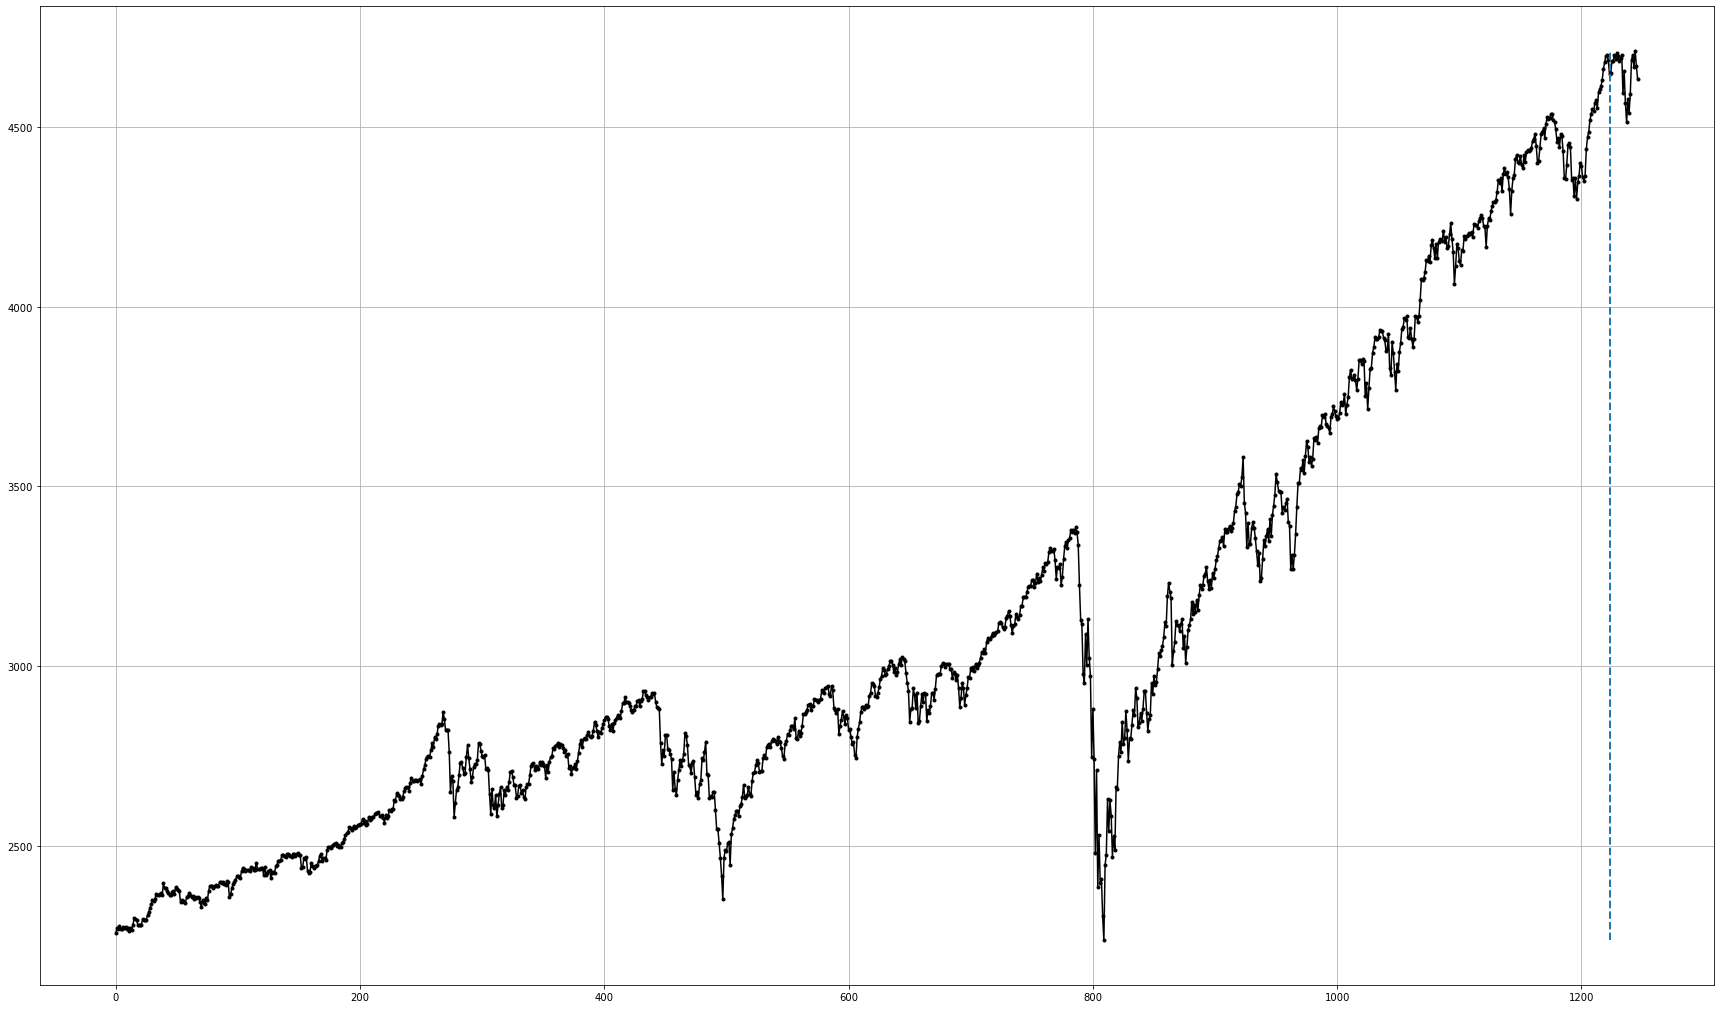

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 18))
plt.plot(data, ".-k")
plt.grid()

# linea vertical para dividir el entrenamiento
# del pronóstico
plt.plot(
    [len(data) - 24, len(data) - 24],
    [min(data), max(data)],
    "--",
    linewidth=2);

## Análisis exploratorio

La inspección visual revela que la serie tiene un componente cíclico con un año de periodo, lo cual se explica porque la contratación de mano de obra es estacionaria (por periodos en el año); la serie presenta también una tendencia creciente en el largo plazo, cuya pendiente cambia aproximadamente sobre la mitad derecha de la gráfica.

La función de autocorrelación (ACF) simple, definida como:

$$
\text{acf}(k) = \frac{1}{T-k} \sum (z_{t+k} - \bar{z})(z_t - \bar{z})
$$

donde:

$$
\bar{z} = \frac{1}{T} \sum_t z_t
$$

presenta el siguiente comportamiento:

In [35]:
from statsmodels.tsa.stattools import acf, pacf

def acf_plot(z):
    acf_data = acf(z, fft=False)
    fig = plt.figure(figsize=(25, 15))
    plt.stem(range(len(acf_data)), acf_data, use_line_collection=True)
    plt.ylim(-1, 1),
    plt.grid()


def pacf_plot(z):
    pacf_data = pacf(z)
    fig = plt.figure(figsize=(25, 15))
    plt.stem(range(len(pacf_data)), pacf_data, use_line_collection=True)
    plt.ylim(-1, 1)
    plt.grid()

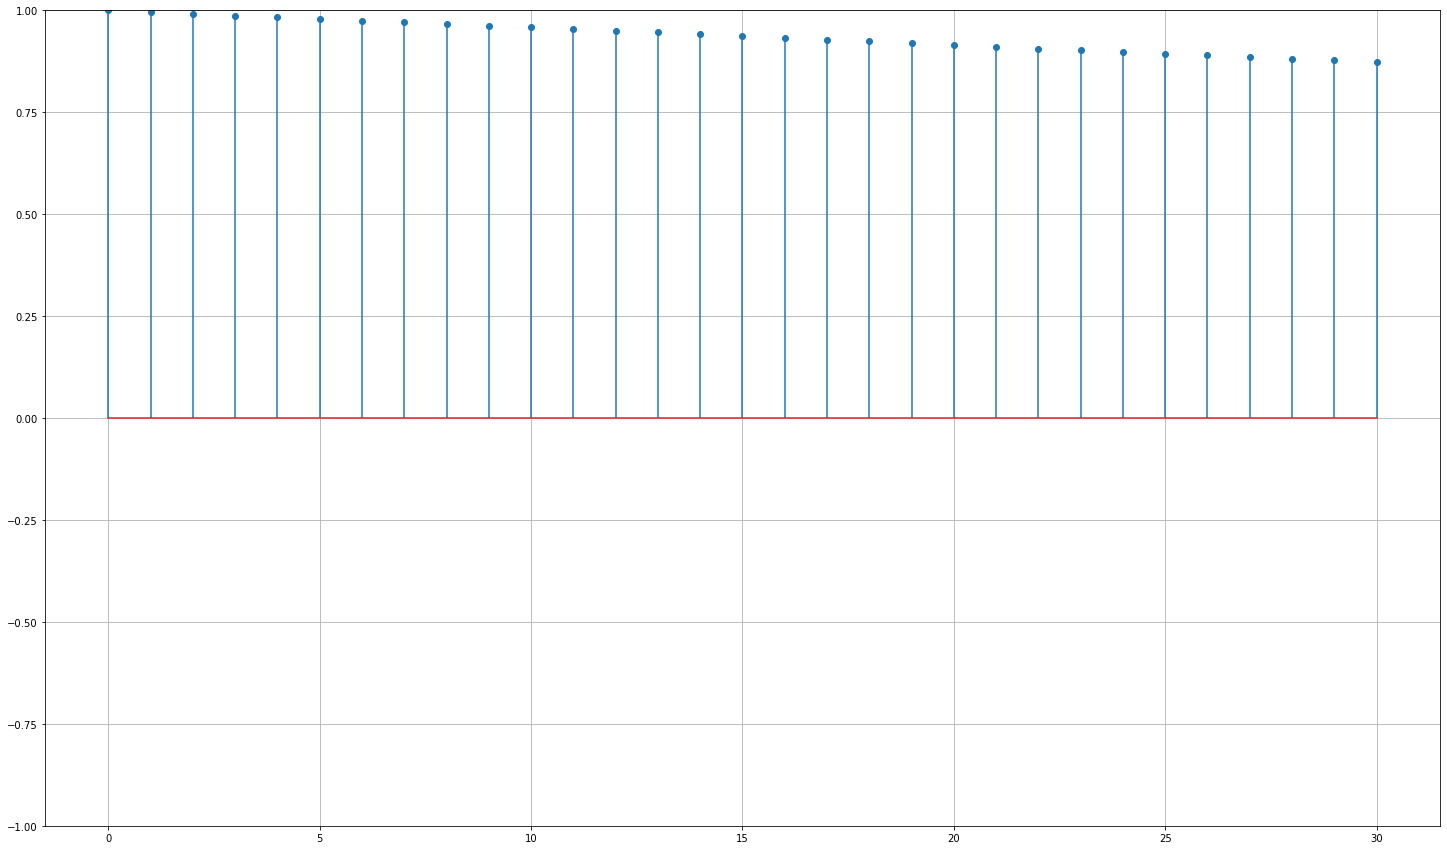

In [36]:
acf_plot(data)

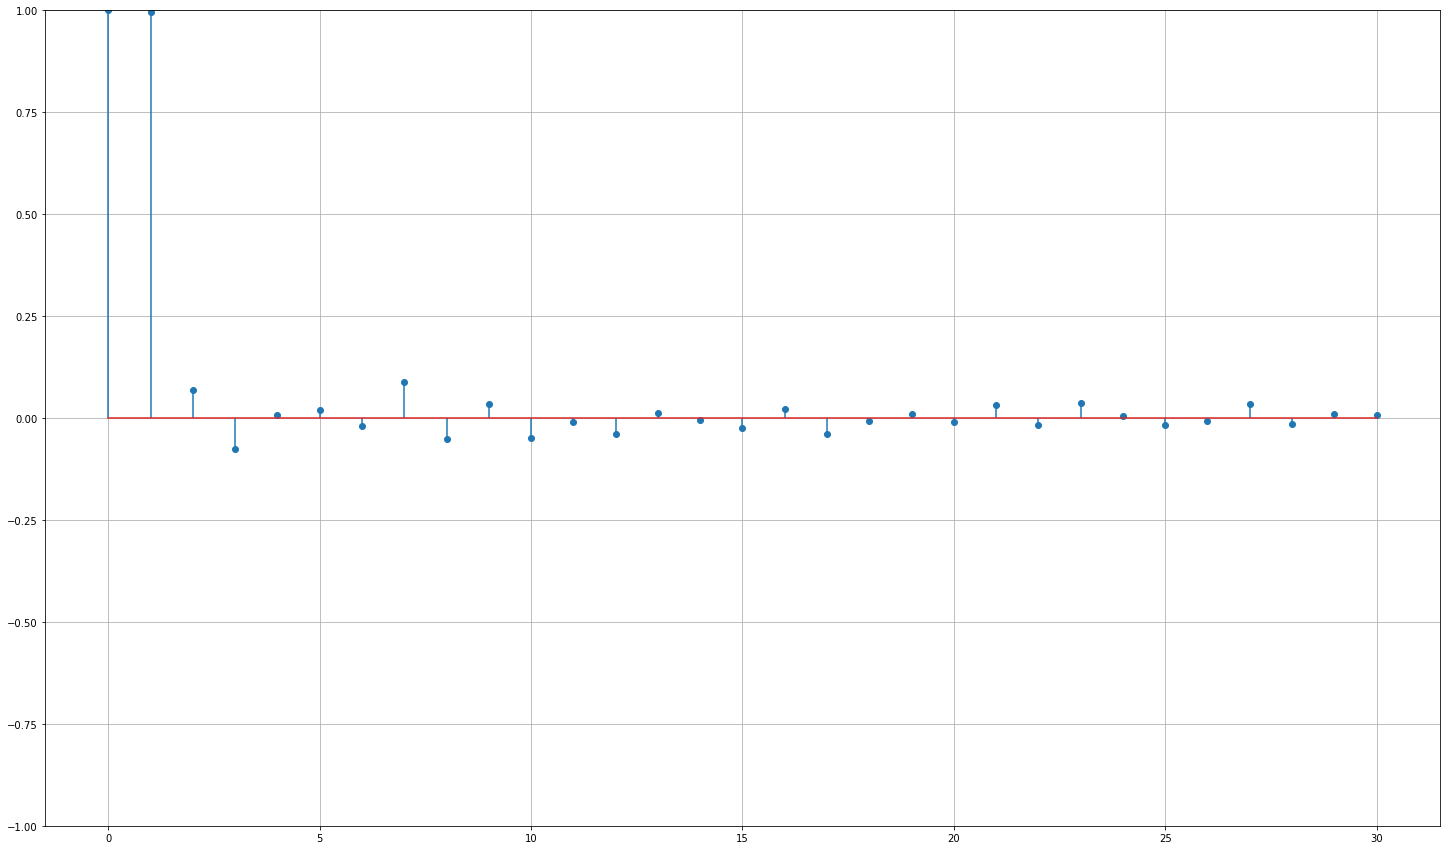

In [37]:
pacf_plot(data)

que se interpreta de la siguiente manera:

* El comportamiento cíclico corresponde a la componente periodica dentro del año, y tiene un periodo de 12 meses.

* La tendencia decreciente que muere en el largo plazo representa la tendencia de largo plazo.

Existen dos tendencias para modelar la serie usando una red neuronal artificial:

* Usar directamente los datos de la serie y dejar que el modelo capture tanto la tendencia como el patrón cíclico.

* Remover la tendencia y el ciclo, y la serie que queda es pronósticada usando el modelo de redes neuronales artificiales. 

En el pronóstico de series de tiempo, el valor actual de la serie $z_t$ es función de sus valores pasados $z_{t-1}$, ..., $z_{t-P}$; estos últimos son la entrada a la red neuronal.

## Modelo 1: Pronostico de la serie sin transformar

En este caso se tomará a $P$ = 13. En la práctica deberían tantearse diferentes valores de $P$.

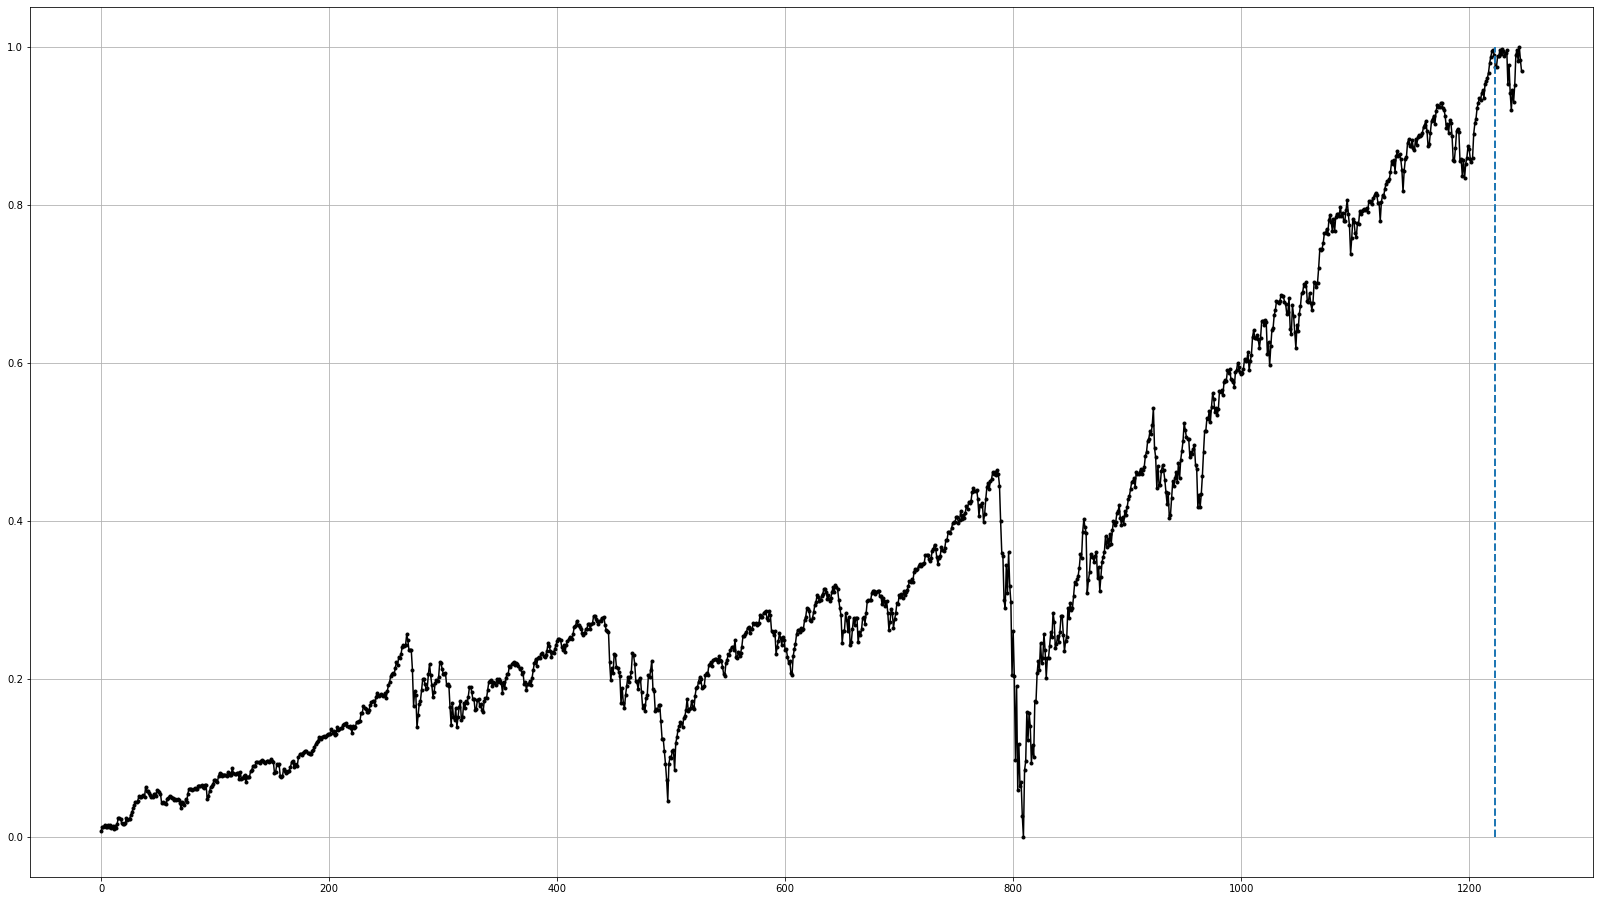

In [38]:
#
# Como primer paso se escala la serie al intervalo [0, 1]
# ya que esto facilita el entrenamiento del modelo
#
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# crea el transformador
scaler = MinMaxScaler()

# escala la serie
data_scaled = scaler.fit_transform(np.array(data).reshape(-1, 1))

# z es un array de listas como efecto
# del escalamiento
data_scaled = [u[0] for u in data_scaled]

plt.figure(figsize=(28, 16))
plt.plot(data_scaled, ".-k")
plt.grid()
plt.plot(
    [len(data_scaled) - 24, len(data_scaled) - 24],
    [min(data_scaled), max(data_scaled)],
    "--",
    linewidth=2,
);

Ya que la implementación dispobible en `sklearn` es para modelos de regresión, se debe armar una matrix donde las variables independientes son $z_{t-1}$, ..., $z_{t-P}$ y la variable dependiente es $z_t$.

In [39]:
P = 5

X = []
for t in range(P - 1, 1248 - 1):
    X.append([data_scaled[t - n] for n in range(P)])

observed_scaled = data_scaled[P:]

In [40]:
#
# Numero total de patrones al convertir
# los datos a un modelo de regresión
#
len(X)

1243

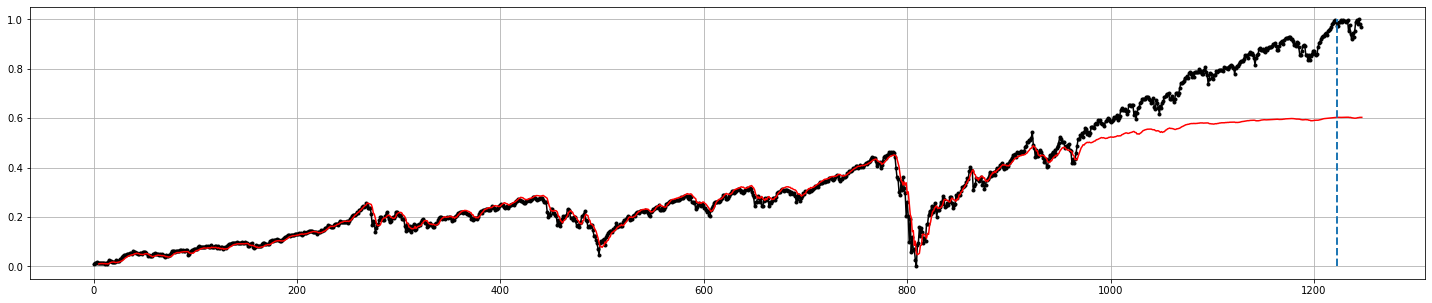

In [41]:
from sklearn.neural_network import MLPRegressor

np.random.seed(123456)

H = 1  # Se escoge arbitrariamente

mlp = MLPRegressor(
    hidden_layer_sizes=(H,),
    activation="logistic",
    learning_rate="adaptive",
    momentum=0.0,
    learning_rate_init=0.1,
    max_iter=10000,
)

# Entrenamiento
mlp.fit(X[0:998], observed_scaled[0:998])

# Pronostico
y_scaled_m1 = mlp.predict(X)

plt.figure(figsize=(25, 5))
plt.plot(data_scaled, ".-k")
plt.grid()

#
# No hay pronóstico para los primeros 13 valores
# de la serie
#
plt.plot([None] * P + y_scaled_m1.tolist(), "-r")

#
# linea vertical para dividir el entrenamiento
# del pronóstico. Se ubica en el ultimo dato
# usando para entrenamiento
#
plt.plot(
    [len(data_scaled) - 24, len(data_scaled) - 24],
    [min(data_scaled), max(data_scaled)],
    "--",
    linewidth=2,
);

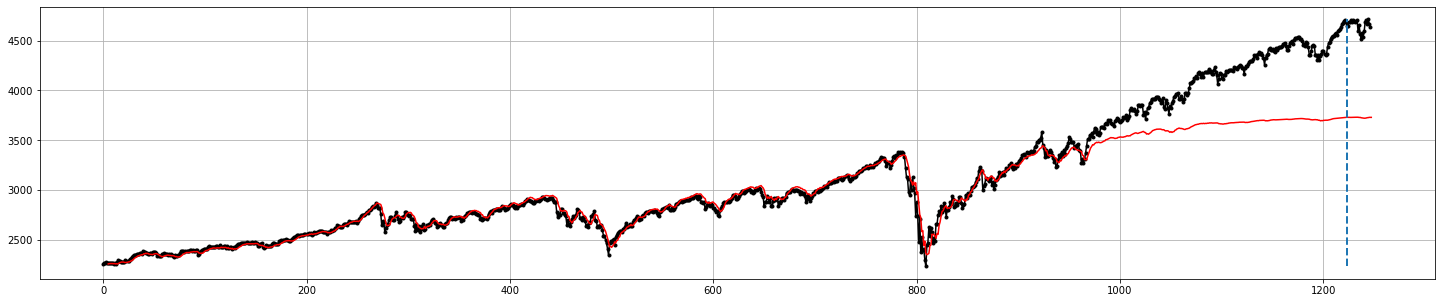

In [42]:
#
# Se desescala para llevar los valores a la escala de los datos originales
#
y_m1 = scaler.inverse_transform([[u] for u in y_scaled_m1])
y_m1 = [u[0] for u in y_m1]

plt.figure(figsize=(25, 5))
plt.plot(data, ".-k")
plt.grid()
plt.plot([None] * P + y_m1, "-r")
plt.plot([len(data) - 24, len(data) - 24], [min(data), max(data)], "--", linewidth=2);

**Ejercicio.---** Determine el número óptimo de neuronas en la capa oculta y la cantidad de rezagos $P$. Recuerde que los resultados son sensibles a los parámetros de la optimización y el punto de arranque.

## Modelo 2: Pronóstico de la serie transformada

Este es el procedimiento común usado en Estadística Aplicada y Econometría. Acá se juzga el modelo por la precisión, no por el cumplimiento de criterios estadísticos.

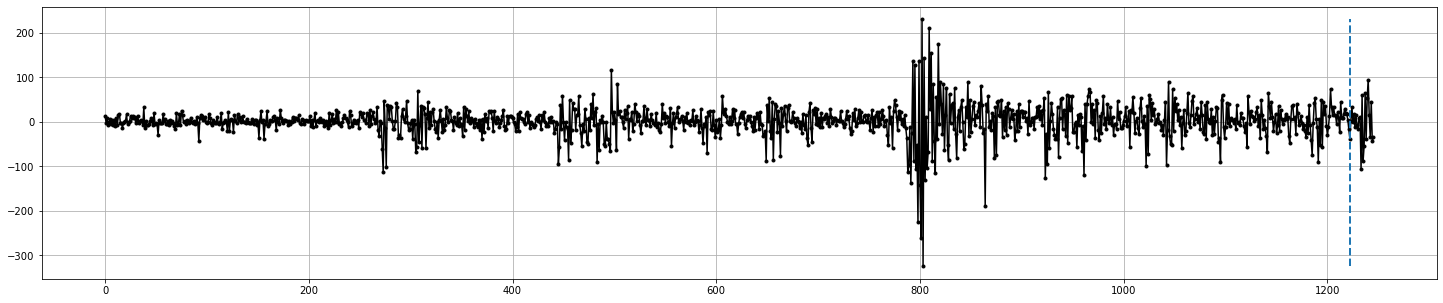

In [43]:
# Se remueve la tendencia
data_d1 = [data[t] - data[t - 1] for t in range(1, len(data))]

# En la gráfica queda la componente cíclica
plt.figure(figsize=(25, 5))
plt.plot(data_d1, ".-k")
plt.grid()
plt.plot(
    [len(data_d1) - 24, len(data_d1) - 24],
    [min(data_d1), max(data_d1)],
    "--",
    linewidth=2,
);

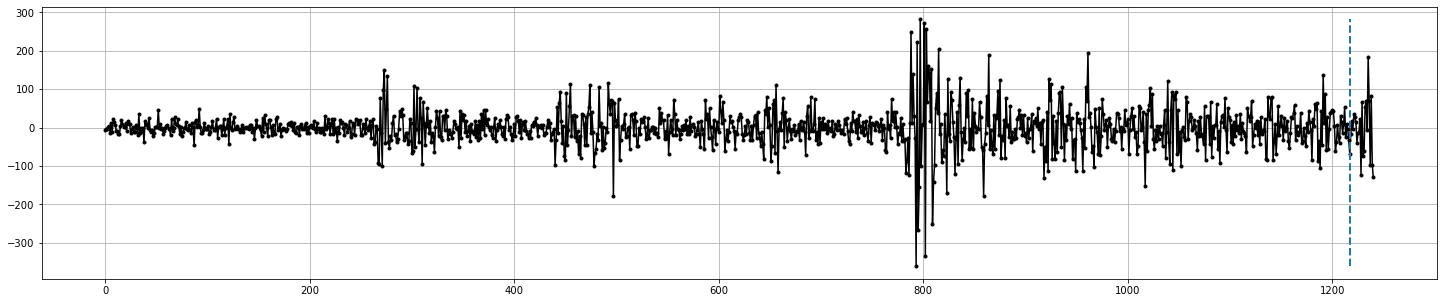

In [44]:
#
# Se remueve la componente cíclica
# restando z[t] - z[t-12]
#
data_d1d5 = [data_d1[t] - data_d1[t - 5] for t in range(5, len(data_d1))]

plt.figure(figsize=(25, 5))
plt.plot(data_d1d5, ".-k")
plt.grid()
plt.plot(
    [len(data_d1d5) - 24, len(data_d1d5) - 24],
    [min(data_d1d5), max(data_d1d5)],
    "--",
    linewidth=2,
);

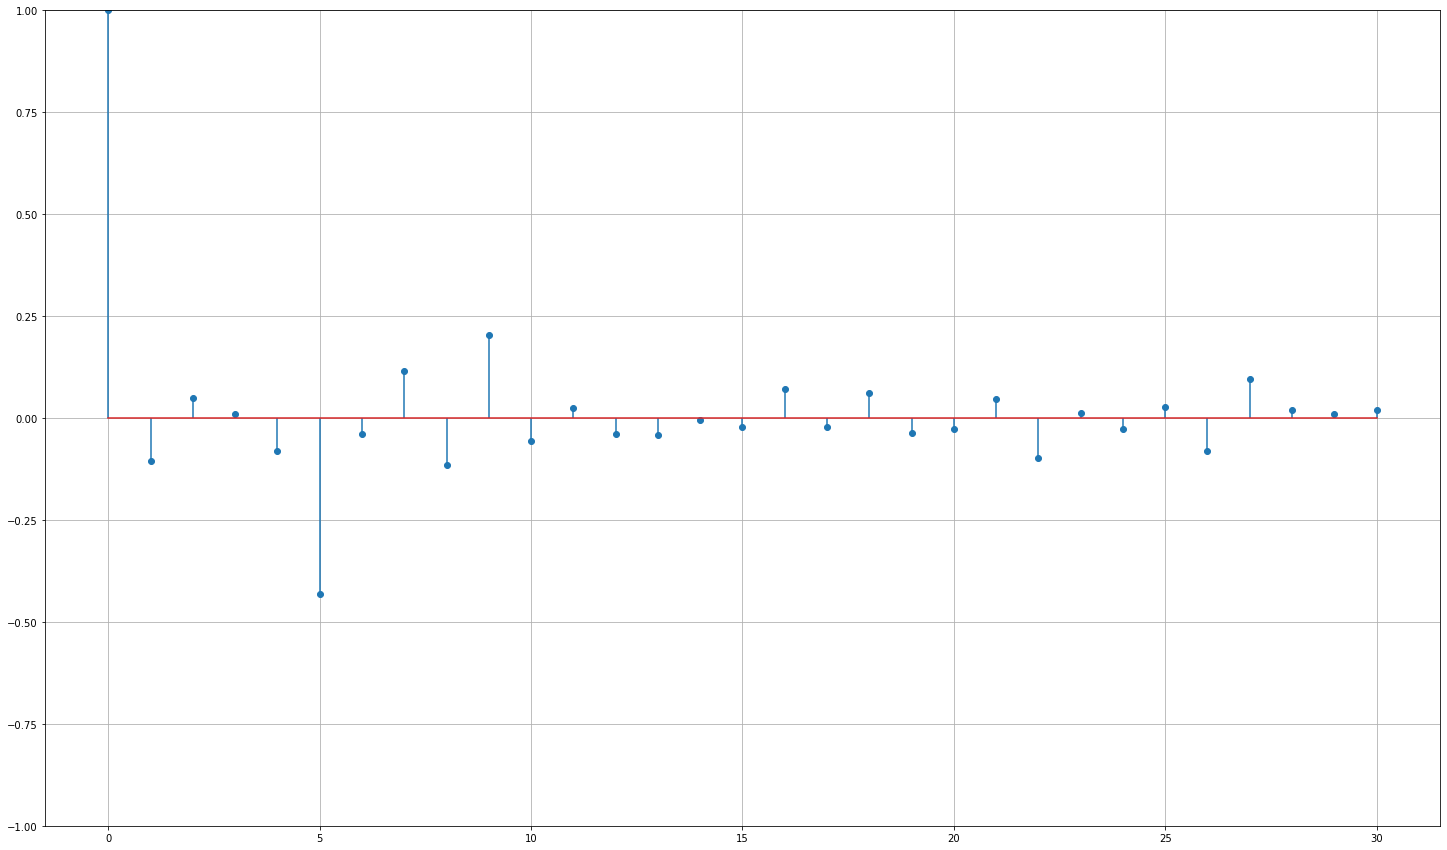

In [45]:
acf_plot(data_d1d5)

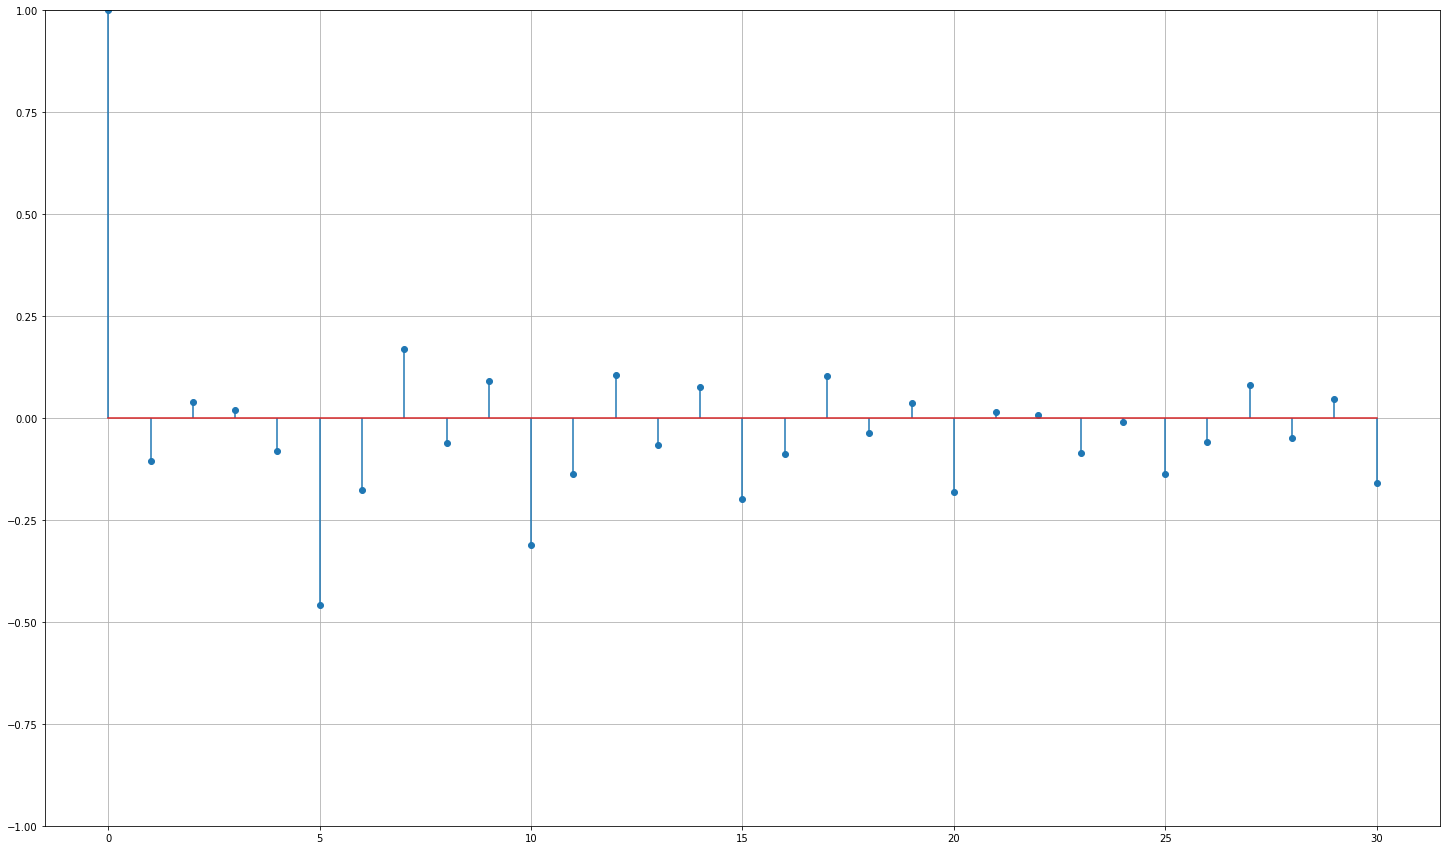

In [46]:
pacf_plot(data_d1d5)

A partir de la gráfica del PACF, se deduce que un valor apropiado para $P$ podría ser 12.

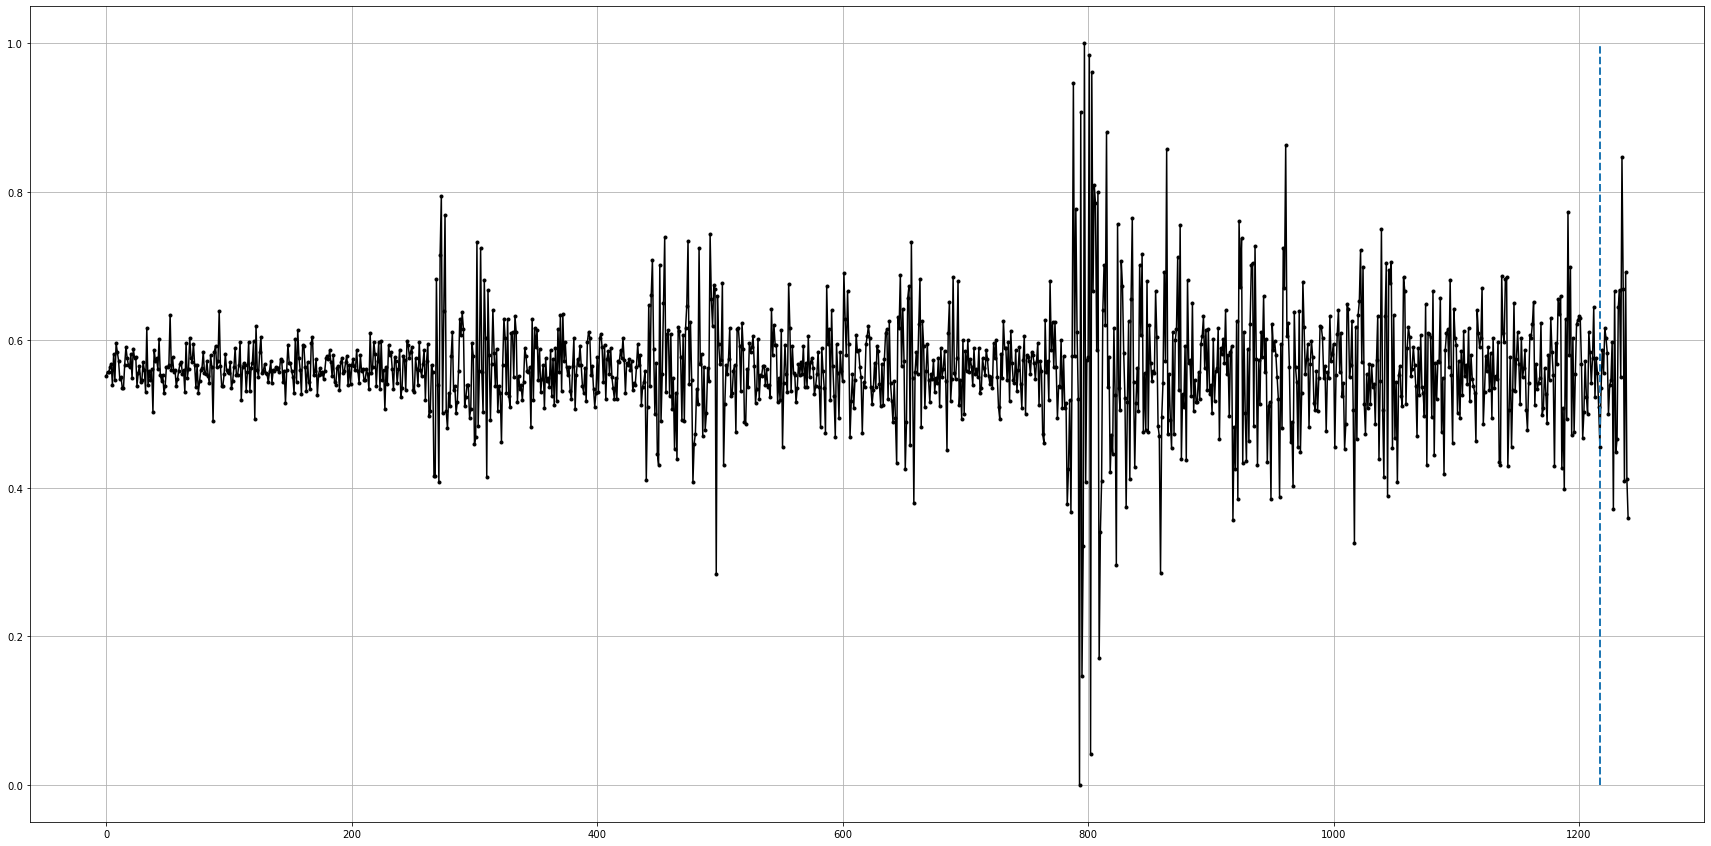

In [47]:
#
# Se escalan los valores como en el caso anaterior
#
scaler = MinMaxScaler()
data_d1d5_scaled = scaler.fit_transform(np.array(data_d1d5).reshape(-1, 1))
data_d1d5_scaled = [u[0] for u in data_d1d5_scaled]

#
# Se verifica visualmente el escalamiento
#
plt.figure(figsize=(30, 15))
plt.plot(data_d1d5_scaled, ".-k")
plt.grid()
plt.plot(
    [len(data_d1d5_scaled) - 24, len(data_d1d5_scaled) - 24],
    [min(data_d1d5_scaled), max(data_d1d5_scaled)],
    "--",
    linewidth=2,
);

In [48]:
#
# La longitud de la serie cambia
#
len(data_d1d5_scaled)

1241

In [49]:
#
# Se construye la matriz de regresores
#
P = 5

X = []
for t in range(P - 1, len(data_d1d5_scaled) - 1):
    X.append([data_d1d5_scaled[t - n] for n in range(P)])

d = data_d1d5_scaled[P:]

In [50]:
X

[[0.5682465123581564,
  0.5640991898765284,
  0.5561614057815253,
  0.557170931425828,
  0.551936719200935],
 [0.5393229579480614,
  0.5682465123581564,
  0.5640991898765284,
  0.5561614057815253,
  0.557170931425828],
 [0.5814503644835074,
  0.5393229579480614,
  0.5682465123581564,
  0.5640991898765284,
  0.5561614057815253],
 [0.5460179863945372,
  0.5814503644835074,
  0.5393229579480614,
  0.5682465123581564,
  0.5640991898765284],
 [0.595616717016537,
  0.5460179863945372,
  0.5814503644835074,
  0.5393229579480614,
  0.5682465123581564],
 [0.5842460906479698,
  0.595616717016537,
  0.5460179863945372,
  0.5814503644835074,
  0.5393229579480614],
 [0.5721450561686113,
  0.5842460906479698,
  0.595616717016537,
  0.5460179863945372,
  0.5814503644835074],
 [0.5471052553735813,
  0.5721450561686113,
  0.5842460906479698,
  0.595616717016537,
  0.5460179863945372],
 [0.5501034934441511,
  0.5471052553735813,
  0.5721450561686113,
  0.5842460906479698,
  0.595616717016537],
 [0.53578

In [51]:
#
# Numero total de patrones al convertir
# los datos a un modelo de regresión
#
len(X)

1236

In [58]:
data_d1d5_scaled[0:998]

[0.551936719200935,
 0.557170931425828,
 0.5561614057815253,
 0.5640991898765284,
 0.5682465123581564,
 0.5393229579480614,
 0.5814503644835074,
 0.5460179863945372,
 0.595616717016537,
 0.5842460906479698,
 0.5721450561686113,
 0.5471052553735813,
 0.5501034934441511,
 0.5357816542416385,
 0.5346629086929184,
 0.5666779931752729,
 0.5908629965239248,
 0.5759047996838691,
 0.5659938518295472,
 0.5634465251004785,
 0.5805182029381671,
 0.5490784191329001,
 0.5884552285616118,
 0.5757182156804893,
 0.5776910002040289,
 0.5383752477357728,
 0.5553691822387199,
 0.5652486535233658,
 0.5435639516671584,
 0.5454434441890081,
 0.5706698289874177,
 0.5596564427228826,
 0.5304533915434972,
 0.616213770657921,
 0.5386862210747391,
 0.5584140663101345,
 0.546157924397072,
 0.5607748090358234,
 0.5034252575579795,
 0.5867782479458694,
 0.572176153502508,
 0.5755160830101612,
 0.5603246561658808,
 0.6012085485812411,
 0.5530698757092657,
 0.5451639474197177,
 0.5532568389484247,
 0.528744934358079,

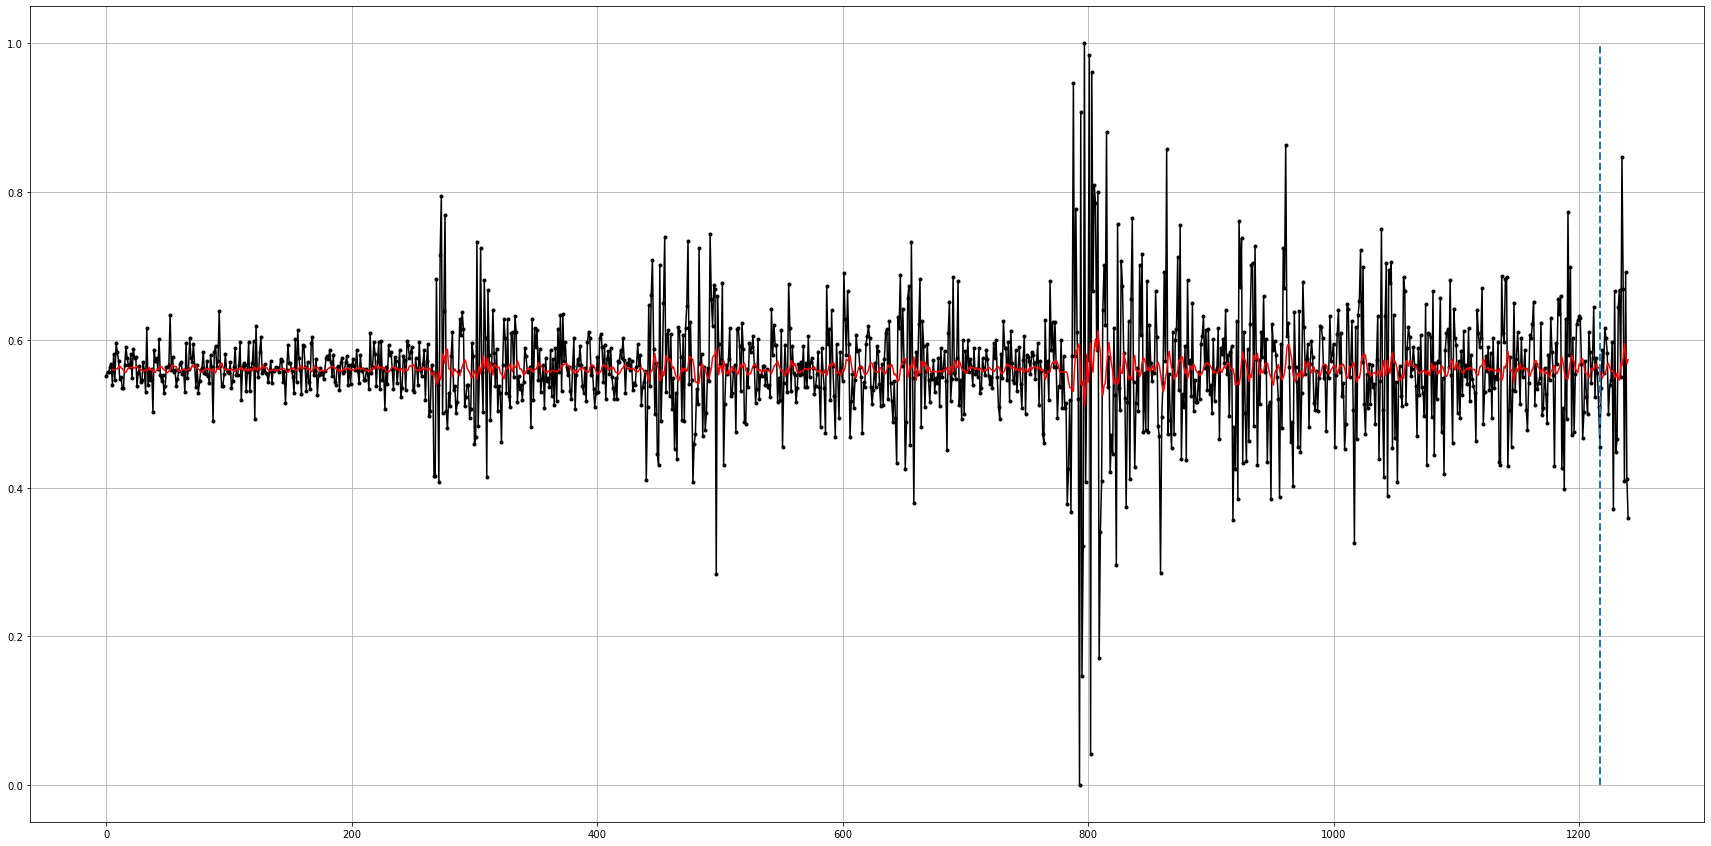

In [52]:
H = 50  # Se escoge arbitrariamente

np.random.seed(123456)

mlp = MLPRegressor(
    hidden_layer_sizes=(H,),
    activation="logistic",
    learning_rate="adaptive",
    momentum=0.0,
    learning_rate_init=0.002,
    max_iter=100000,
)

# Entrenamiento
mlp.fit(X[0:998], data_d1d5_scaled[0:998])

# Pronostico
y_d1d5_scaled_m2 = mlp.predict(X)

plt.figure(figsize=(30, 15))
plt.plot(data_d1d5_scaled, ".-k")
plt.grid()

# No hay pronóstico para los primeros 5 valores de la serie
plt.plot([None] * P + y_d1d5_scaled_m2.tolist(), "-r")

# linea vertical para dividir el entrenamiento
# del pronóstico
plt.plot(
    [len(data_d1d5_scaled) - 24, len(data_d1d5_scaled) - 24],
    [min(data_d1d5_scaled), max(data_d1d5_scaled)],
    "--",
    linewidth=2,
);

In [53]:
print(len(y_d1d5_scaled_m2), ",", len(data_d1d5_scaled) - P)

1236 , 1236


In [54]:
#
# La gráfica anterior no es comparativa. Se realizan las
# transformaciones inversas a las realizadas
#
y_d1d5_scaled_m2 = data_d1d5_scaled[0:P] + y_d1d5_scaled_m2.tolist()

y_d1d5_m2 = scaler.inverse_transform([[u] for u in y_d1d5_scaled_m2])
y_d1d5_m2 = [u[0] for u in y_d1d5_m2.tolist()]

y_d1_m2 = [y_d1d5_m2[t] + data_d1[t] for t in range(len(y_d1d5_m2))]
y_d1_m2 = data_d1[0:5] + y_d1_m2

y_m2 = [y_d1_m2[t] + data[t] for t in range(len(y_d1_m2))]

y_m2 = [data[0]] + y_m2

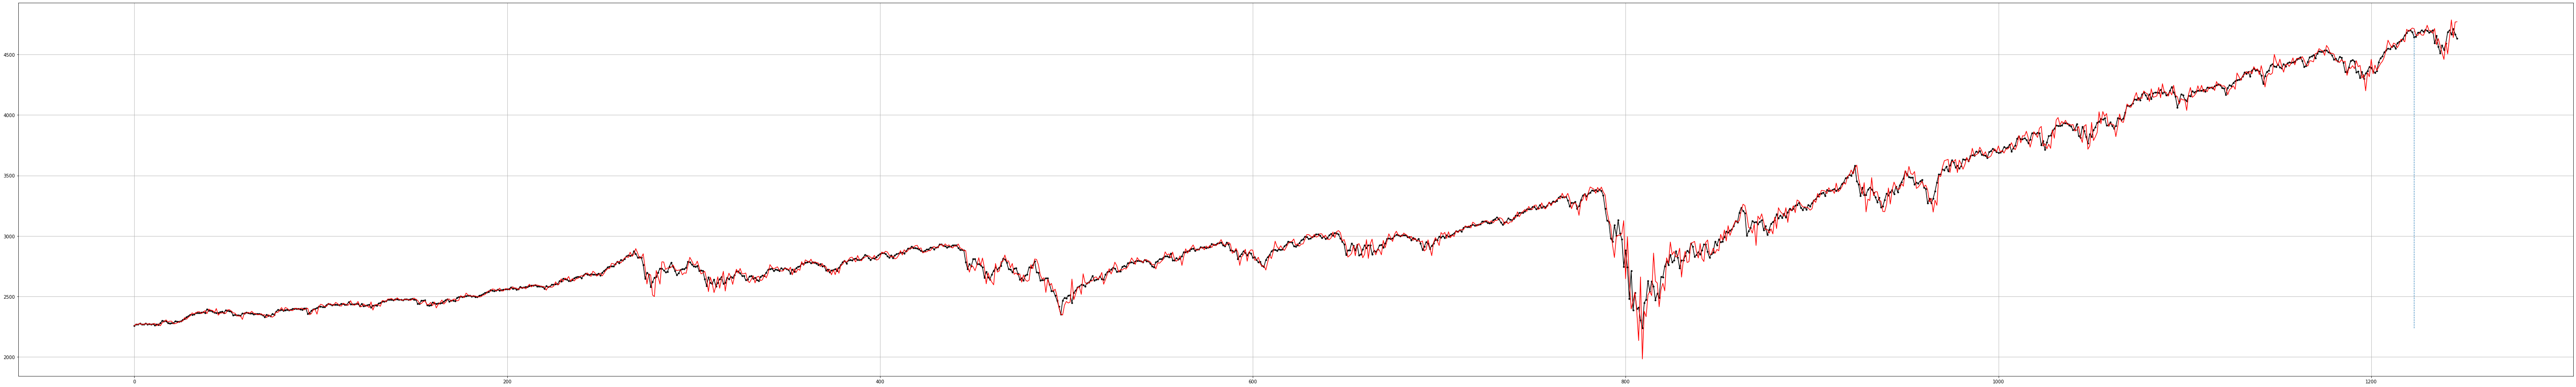

In [55]:
plt.figure(figsize=(100, 15))
plt.plot(data, ".-k")
plt.grid()

plt.plot(y_m2, "-r")

# linea vertical para dividir el entrenamiento
# del pronóstico. Se ubica en el ultimo dato
# usando para entrenamiento
plt.plot([len(data) - 24, len(data) - 24], [min(data), max(data)], "--", linewidth=1);

**Ejercicio.---** Determine el número óptimo de neuronas en la capa oculta y la cantidad de rezagos $P$. Recuerde que los resultados son sensibles a los parámetros de la optimización y el punto de arranque.

In [56]:
a = mlp.predict(X)

In [133]:
len(X)

1236

In [122]:
a

array([0.56069082, 0.56073845, 0.55981515, ..., 0.57915145, 0.56006818,
       0.56156497])

In [38]:
scaler.inverse_transform([[0.957852]])

array([[254.81633239]])